# Signatures and modeling with them

## Computing signatures

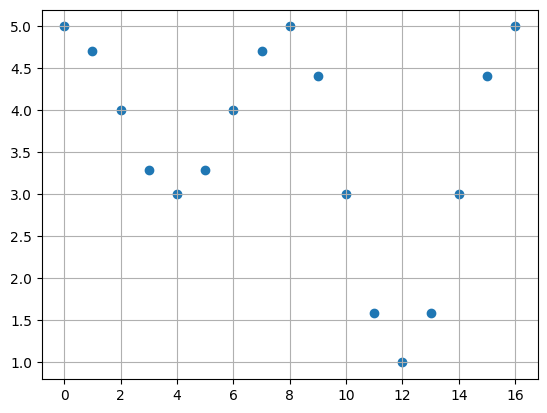

In [4]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array([
    [0.0, 5.0], [1.0, 4.707], [2.0, 4.0], [3.0, 3.292], [4.0, 3.0],
    [5.0, 3.292], [6.0, 4.0], [7.0, 4.707], [8.0, 5], [9.0, 4.414],
    [10.0, 3.0], [11.0, 1.586], [12.0, 1.0], [13.0, 1.586], [14.0, 3.0],
    [15.0, 4.414], [16.0, 5.0]
])

plt.scatter(data[:, 0], data[:, 1])
plt.grid()

In [5]:
from src.util.signature import signature

# f(t) = (t, t^2)
# t = np.linspace(0, 2, 1000)
# data = np.array([t, t**2]).T

# f(t) = (cos(t), sin(t))
t = np.linspace(0, np.pi, 1000)
data = np.array([np.cos(t), np.sin(t)]).T

depth = 2
sig = signature(data, depth)

np.set_printoptions(precision=8, suppress=True)
for x in range(depth+1):
    print(sig[x], '\n')

1.0 

[-2.  0.] 

[[ 2.          1.57079374]
 [-1.57079374 -0.        ]] 



### Comparison with a standard package

In [6]:
import esig

esig.stream2sig(data, depth)

array([ 1.        , -2.        ,  0.        ,  2.        ,  1.57079374,
       -1.57079374,  0.        ])

## Reconstructing asset price with Heston model

### The model

The Heston model is
$$
\begin{aligned}
    \mathrm{d} S_t &= \mu S_t \, \mathrm{d} t +  S_t \sqrt{V_t} \, \mathrm{d} W_t^S \\
    \mathrm{d} V_t &= \kappa (\theta - V_t) \, \mathrm{d} t + \sigma \sqrt{V_t} \, \mathrm{d} W_t^V \\
    \mathrm{d} \left[W^S, W^V \right]_t &= \rho \, \mathrm{d} t
\end{aligned}
$$
where $S_t$ is the price, $V_t$ is the variance of the volatility, and $\mu$, $\kappa$, $\theta$, $\sigma$ are constants.
Brownian motions $W^S$ and $W^V$ are correlated wth coefficient $-1 \leq \rho \leq 1$.

#### The goal

Can we create a model using the signature of $X = (t, W^S, W^V)$ that is able to reconstruct the price and volatility data?
This is also called calibration.

### Creating the model

1.  Observe price and volatility data.
2.  Estimate the underlying Brownian motion.
3.  Use linear regression with Lasso regularization to create a model.

We use the same parameters as [Cuchiero, Gazzani, Svaluto-Ferro: Signature-based models: theory and calibration](https://arxiv.org/abs/2207.13136).

In [7]:
rng = np.random.default_rng()

S0 = 1.0
V0 = 0.08
t0 = 0.0
tn = 1.0
n = 2627999
mu = 0.001
kappa = 0.5
theta = 0.15
sigma = 0.25
rho = -0.5

params = (S0, V0, t0, tn, n, mu, kappa, theta, sigma, rho)

#### Simulate data with Euler-Maruyama

In [8]:
from src.util.heston import *
from src.util.brownian import estimate_brownian

t, u, w = heston_euler(*params, rng)    # Euler-Maruyama
# t, u = heston_qe(*params, rng)         # quadratic exponential

In [9]:
# divide the data into sections
n_div = 1095
div_size = (n+1) // 1095
z = np.reshape(u, shape=(n_div, div_size, u.shape[1]))

# quadratic variance for each section
delta = np.diff(z, axis=1)
qv = n_div*np.sum(delta**2, axis=1)

# choose the first data point in each section
u = u[::div_size, :]
w = w[::div_size, :]

# Brownian increment
dw = np.diff(u, axis=0) / np.sqrt(qv)[:-1]

# estimated Brownian motion
w_est = np.zeros((n_div, u.shape[1]))
w_est[1:] = np.cumsum(dw, axis=0)

# consolidate data for signature
t = np.linspace(0.0, 1.0, n_div)
brownian_data = np.column_stack((t, w_est))

# can also directly input the Brownian motions used to generate the Heston model
# brownian_data = np.column_stack((t, w))

#### Compute the signature for each time

In [10]:
import pandas as pd

samples, channels = brownian_data.shape
depth = 2

# get the indices of depth
keys = esig.sigkeys(channels, depth+1).strip().split(' ')

# compute the signature for each time for depth+1
features = len(keys)
data = np.zeros((samples, features))

for i in range(2, samples+1):
    data[i-1, :] = esig.stream2sig(brownian_data[:i, :], depth+1)

# save to a DataFrame
sig_df = pd.DataFrame(data, columns=keys)

#### Transforming the signature

In [11]:
def tilde_transformation(word):
    """
    Computes the tilde transformation for a word (list) of integers.
    """
    word_aux = word.copy()
    word_aux_2 = word.copy()
    if word[-1] == 1:
        word.append(2)
        word_aux.append(3)
        return word, word_aux
    if word[-1] != 1:
        word_aux.append(2)
        word_aux_2.append(3)
        word[-1] = 1
        return word_aux, word_aux_2, word

def e_tilde_part2_new(words_as_lists):
    """
    Applies the tilde transformation to each word in a list.
    """
    # we skip the empty word
    tilde = [list(tilde_transformation(words_as_lists[k])) for k in 
                np.array(range(len(words_as_lists)))[1:]]
    return tilde

def from_tilde_to_strings_new(tilde):
    """
    Converts a list of tilde transformations to strings.
    Used in the DataFrame.
    """
    for k in range(len(tilde)):
        if len(tilde[k]) == 2:
            tilde[k][0] = str(tuple(tilde[k][0])).replace(" ","")
            tilde[k][1] = str(tuple(tilde[k][1])).replace(" ","")
        elif (len(tilde[k]) == 3 and len(tilde[k][-1]) == 1):
            tilde[k][0] = str(tuple(tilde[k][0])).replace(" ","")
            tilde[k][1] = str(tuple(tilde[k][1])).replace(" ","")
            tilde[k][-1] = str(tuple(tilde[k][-1])).replace(",","")
        elif len(tilde[k]) == 3:
            tilde[k][0] = str(tuple(tilde[k][0])).replace(" ","")
            tilde[k][1] = str(tuple(tilde[k][1])).replace(" ","")
            tilde[k][2] = str(tuple(tilde[k][2])).replace(" ","")
    return tilde

def get_tilde_df_debug(Sig_data_frame, new_tilde, keys_n,
                        keys_n1, comp_of_path, rho, y):
    """
    Applies the tilde tranformation to the sig_df in the case of (t,B,W) as
    augmented noises. It returns a dataframe similar to sig_df but where
    the components are the result of the tilde transformation.
    """
    aus_B = []
    y = [[eval(key)] if isinstance(eval(key), int) else
            list(eval(key)) for key in keys_n]
    for k in range(len(y)):
        if k == 0:
            aus_B.insert(0, Sig_data_frame['(2)'])
        if (k > 0 and y[k][-1] == 1):
            aus_B.append(Sig_data_frame[new_tilde[k-1][0]])
           
        if (k > 0 and y[k][-1] == 2):
            aus_B.append(Sig_data_frame[new_tilde[k-1][0]] 
                            - 0.5 * Sig_data_frame[new_tilde[k-1][2]])
        
        if (k > 0 and y[k][-1] == 3):
            aus_B.append(Sig_data_frame[new_tilde[k-1][0]]
                            - rho * 0.5 * Sig_data_frame[new_tilde[k-1][2]])

    new_keys_B = [keys_n1[k]+str('~B') for k in range(len(y))]
    new_dictionary_B = {key:series for key, series in zip(new_keys_B, aus_B)}        
    transformed_data_frame_B = pd.DataFrame(new_dictionary_B)
    return transformed_data_frame_B, new_keys_B

In [12]:
# get the indices of depth+1
keys_n = esig.sigkeys(channels, depth).strip().split(' ')

# perform tilde transformation on depth keys
y=[[eval(key)] if isinstance(eval(key), int) else list(eval(key)) for key in keys_n]
first_step=e_tilde_part2_new(y)
new_tilde=from_tilde_to_strings_new(first_step)

# transform the signature
transformed_df_x, new_keys_B=get_tilde_df_debug(sig_df,new_tilde,keys_n,keys,3,rho,y)

#### Perform linear regression

In [13]:
import sklearn

# price
s = u[:, 0]

lasso_reg = 1e-5
model_sig = sklearn.linear_model.Lasso(alpha=lasso_reg, max_iter=10000)
model_sig.fit(transformed_df_x[new_keys_B], s)

# try linear regression with Brownian motion
# model_brown = sklearn.linear_model.Lasso(alpha=lasso_reg, max_iter=10000)
# model_brown.fit(brownian_data, s)

Lasso(alpha=1e-05, max_iter=10000)

### Testing the model

To test the model, we

1.  Generate new data the model has not seen and estimate the Brownian motions.
2.  Feed the data into the model.
3.  Evaluate using mean squared error (as is used in the above paper)

In [14]:
# simulate new data
t, u, w = heston_euler(*params, rng)    # Euler-Maruyama
# t, u = heston_qe(*params, rng)          # quadratic exponential

# divide the data into sections
n_div = 1095
div_size = (n+1) // 1095
z = np.reshape(u, shape=(n_div, div_size, u.shape[1]))

# quadratic variance for each section
delta = np.diff(z, axis=1)
qv = n_div*np.sum(delta**2, axis=1)

# choose the first data point in each section
u = u[::div_size, :]
w = w[::div_size, :]

# Brownian increment
dw = np.diff(u, axis=0) / np.sqrt(qv)[:-1]

# estimated Brownian motion
w_est = np.zeros((n_div, u.shape[1]))
w_est[1:] = np.cumsum(dw, axis=0)

# consolidate data for signature
t = np.linspace(0.0, 1.0, n_div)
brownian_data = np.column_stack((t, w_est))

# can also directly input the Brownian motions used to generate the Heston model
# brownian_data = np.column_stack((t, w))

import pandas as pd

samples, channels = brownian_data.shape
depth = 2

# get the indices of depth
keys = esig.sigkeys(channels, depth+1).strip().split(' ')

# compute the signature for each time for depth+1
features = len(keys)
data = np.zeros((samples, features))

for i in range(2, samples+1):
    data[i-1, :] = esig.stream2sig(brownian_data[:i, :], depth+1)

# save to a DataFrame
sig_df = pd.DataFrame(data, columns=keys)


# get the indices of depth+1
keys_n = esig.sigkeys(channels, depth).strip().split(' ')

# perform tilde transformation on depth keys
y=[[eval(key)] if isinstance(eval(key), int) else list(eval(key)) for key in keys_n]
first_step=e_tilde_part2_new(y)
new_tilde=from_tilde_to_strings_new(first_step)

# transform the signature
transformed_df_x, new_keys_B=get_tilde_df_debug(sig_df,new_tilde,keys_n,keys,3,rho,y)

# make prediction using the model
s_real = u[:, 0]
s_predicted = model_sig.predict(transformed_df_x[new_keys_B])

In [15]:
# s_predicted_brown = model_brown.predict(brownian_data)

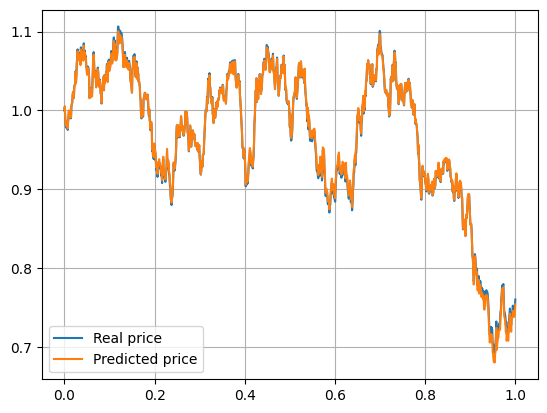

In [16]:
plt.plot(t, s_real, label="Real price")
plt.plot(t, s_predicted, label="Predicted price")
# plt.plot(t, s_predicted_brown, label="Brownian prediction")
plt.legend()
plt.grid()
plt.show()

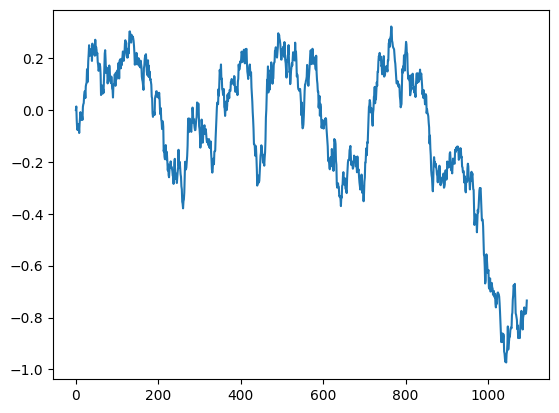

In [17]:
plt.plot(w_est[:, 0])
plt.show()